# Bayesian Dynamic Linear Model for Election Forecasting

## Adam Gayoso and Srikar Varadaraj

## Introduction

The electoral victory of Donald Trump in November 2016 was widely viewed as an upset victory over Hillary Clinton. Various academic and journalistic sources ran forecasting models for the election, with many giving Clinton over a 90% chance of victory. Here we revisit the election and use a Bayesian dynamic linear model adapated from Linzer and Kremp to develop our own forecast of the election. By incorporating the uncertainty of undecided voters in the polls, we believe that Hillary Clinton had a 70% chance of victory on election night. We will intersperse our model with its corresponding code. The code is essentially a copy from run_model.py in /src

In [68]:
%matplotlib inline
import pandas as pd
import numpy as np
import edward as ed
import tensorflow as tf
from edward.models import Normal, Binomial
from edward.models import MultivariateNormalFullCovariance
from scipy.special import logit
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import collections

import sys
sys.path.insert(0, '../src')
from helper import *
from plots import *

ELECTION_DATE = dt.date(2016, 11, 8)
BURN_IN = 5000
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Criticism of 2016 Models

The election of Donald Trump came as a surprise to many. Below we see the final forecasted probability ([source](https://www.buzzfeed.com/jsvine/2016-election-forecast-grades?utm_term=.dsWz0w4MY#.rf1MnvgVW)) that Trump wins the electoral college from many of the most popular forecasters.

|            Organization           	| Pr(Trump wins) 	|
|:---------------------------------:	|---------------:	|
|          FiveThirtyEight          	|           0.29 	|
|             PollSavvy             	|           0.18 	|
|    The New York Times / Upshot    	|           0.15 	|
|           Kremp / Slate           	|           0.10 	|
|         Linzer / Daily Kos        	|           0.08 	|
|        The Huffington Post        	|           0.02 	|
| The Princeton Election Consortium 	|           0.01 	|

What most of these organizations failed to take into account was the power of the undecided voter. 

## Bayesian Dynamic Linear Model for Two-Party Voter Share

## Data

The data consists of polls from May 1, 2016 to November 6, 2016. The polls come from the Huffington Post's pollster database and consist of national polls and state polls. A pollster is a firm that gives a poll. We remove any polls that have overlapping dates and are from the same pollster in the same state. Since polls are taken over several days, we calculate the poll date as the midpoint date in the poll's date range. While more than two candidates run for president, we only consider Hillary Clinton and Donald Trump, as well as undecided voters in each poll.

In [22]:
polls = pd.read_csv('../data/all_polls_2016.csv',
                    parse_dates=['begin', 'end', 'poll_date'])
up_to_t = dt.date(2016, 11, 8)
state_polls, national_polls = prepare_polls(polls, up_to_t)

# Get prior information from 2012 election
prior_diff_score, state_weights, ev_states = process_2012_polls()
prior_diff_score = prior_diff_score[state_polls.state.unique()]
state_weights = state_weights[state_polls.state.unique()].as_matrix()
state_weights_np = state_weights
state_weights = tf.convert_to_tensor(state_weights, dtype=tf.float32)
ev_states = ev_states[state_polls.state.unique()].as_matrix()

n_states = len(state_polls.state.unique())
n_pollsters = len(polls.pollster.unique())
# Week of last poll
w_last = state_polls.week_index.max()
# Days until election
days_until_E = (ELECTION_DATE - state_polls.poll_date.max().date()).days
# Election day as index
E_day = days_until_E + state_polls.date_index.max()
E_week = (ELECTION_DATE + dt.timedelta(days=-1)
          ).isocalendar()[1] - polls.week.min()

## Model

Our model is an adaptation of the models of Kremp and Linzer. 

Polls are binomially distributed with sample size $N_i$.

$$ N^{Clinton}_i \sim \textrm{Binomial}(N_i, \pi^{Clinton}_i) $$

#### State Poll:

$$\textrm{logit} (\pi^{Clinton}_i) = \mu_a[t_i] + \mu_b^{weekly}[w_t, s] + \mu_c[p_i]$$

There is signal, which are the terms $ \mu_a$ and  $\mu_b$, representing a national component shared across all states and a state component, respectively. The other term is noise: pollster house effect ($\mu_c$). In order to reduce the number of parameters in the model, $\mu_b$ is treated as a weekly parameter.

$w_t$ is the week of day $t$.

#### National Poll:

$$\textrm{logit} (\pi^{Clinton}_i) = \textrm{logit}\left( \sum_{s \in {1 \dots S}} \omega_s \cdot \textrm{logit}^{-1} (\mu_a[t_i] + \mu_b^{weekly}[w_{t_i}, s]) \right) + \alpha + \mu_c[p_i]$$

This is the weighted average of the state polls, weighted by 2012 turnout adjusted for population growth from 2011 and 2015. We have a new term $\alpha$, which compensates for the difference in the weighted average and the actual poll. 


We will start backwards from election day, as this is the most intuitive way to understand the model. The model is made up of two components. The forward component covers dates from the last day of polling to election day. The backward component covers days from May 1, 2016 until the last day of polling. The last day of polling could be any time during the election process, so the model could be run every week during the election.

#### Latent variables

|      Effect     |                  Description |                             Structure |
|:---------------:|-----------------------------:|--------------------------------------:|
| $\mu_b$ | Latent state voter intention | One variable for each (week, state) |
|    $\mu_a$    |       Latent national swings |      One variable for each day |
|   $\mu_c$   |         Latent house effects |      One variable for every pollster |

### $\mu_b$ priors

State component

#### Election day

This prior depends on the Time-for-Change model, which is a baseline prediction of the election based on GDP figures, the previous president's party and length of term. This has nothing to do with the two candidates. $48.6\%$ is the prior from this model. $\delta_{1 \dots S}$ represents the difference in Obama's state averages and national average in 2012.

Let time $T$ be election day.

$$\mu_b[T, 1 \dots S] \sim \textrm{Multivariate Normal}(\textrm{logit} (0.486 + \delta_{1 \dots S}), \mathbf{\Sigma})$$

$$\delta_{1 \dots S} = \pi_s^{Obama} - \pi_*^{Obama}$$


In [3]:
mu_b_prior_cov = covariance_matrix(0.05, 0.5, n_states)
mu_b_prior_cov = tf.convert_to_tensor(mu_b_prior_cov, dtype=tf.float32)
mu_b_prior_mean = logit(0.486 + prior_diff_score).as_matrix()
mu_b_prior_mean = tf.convert_to_tensor(mu_b_prior_mean, dtype=tf.float32)
mu_b_prior = MultivariateNormalFullCovariance(
    loc=mu_b_prior_mean, covariance_matrix=mu_b_prior_cov)

#### Forward Component $(t \geq t_{last})$

$$\mu_b^{weekly}[w_t-1, 1 \dots S] \sim \textrm{Multivariate Normal}(\mu_b^{weekly}[w_t, 1 \dots S], \mathbf{\Sigma_b^{walk}})$$

$$\mathbf{\Sigma_b^{walk}} = \textrm{cov-matrix}(\textrm{var}=0.015^2 \cdot 7, \rho=0.75)$$


In [4]:
mu_bs = []
mu_bs.append(mu_b_prior)
sigma_walk_b_forecast = covariance_matrix(7 * 0.015 ** 2, 0.75, n_states)
sigma_walk_b_forecast = tf.convert_to_tensor(
    sigma_walk_b_forecast, dtype=tf.float32)
for w in range(E_week - state_polls.week_index.max()):
    mu_bs.append(MultivariateNormalFullCovariance(
        loc=mu_bs[-1], covariance_matrix=sigma_walk_b_forecast))

#### Backward Component $(t < t_{last})$

$$\mu_b^{weekly}[w_t-1, s] \sim \textrm{Normal}(\mu_b^{weekly}[w_t, s], \sigma_b \cdot \sqrt{7})$$

$$\sigma_b = 0.005$$

In [5]:
sigma_b = 0.005 * np.sqrt(7) * tf.ones(n_states)
for w in range(w_last):
    mu_bs.append(Normal(loc=mu_bs[-1], scale=sigma_b))

### $\mu_a$ Priors

National Component

$$\mu_a[t-1] \sim \textrm{Normal}(\mu_a[t], \sigma_a)$$

$$\sigma_a = 0.025$$

$$\mu_a[T] = 0 $$

In [6]:
sigma_a = 0.02
mu_a_buffer = tf.zeros(1, tf.float32)
mu_as = []
for t in range(E_day):
    if t == 0:
        mu_as.append(Normal(loc=0.0, scale=sigma_a))
    else:
        mu_as.append(Normal(loc=mu_as[-1], scale=sigma_a))

### $\mu_c$ Priors
House Effect

$$\mu_c[p] \sim \textrm{Normal}(0 , \sigma_c)$$

$$\sigma_c = 0.05$$

In [7]:
sigma_c = 0.05 * tf.ones(n_pollsters)
mu_c = Normal(loc=tf.zeros(n_pollsters), scale=sigma_c)

### $\alpha$ Prior

$$\alpha \sim \textrm{Normal}(\sum_{s \in {1 \dots S}} \omega_s \delta_s, \sigma_{\alpha})$$

$$\sigma_{\alpha} = 0.2$$

In [8]:
alpha_mean = (state_weights_np * prior_diff_score).sum().astype(np.float32)
alpha = Normal(loc=alpha_mean, scale=0.2)

### Assembly

State polls

In [9]:
mu_b_tf = tf.stack(mu_bs)
mu_a_tf = tf.stack(mu_as)
mu_a_tf = tf.concat([mu_a_buffer, mu_a_tf], axis=0)
# Due to list in reverse
mu_a_state = tf.gather(
    mu_a_tf, (E_day - state_polls.date_index).as_matrix())
state_ind = state_polls[['week_index', 'state_index']].as_matrix()
# Due to list in reverse
state_ind[:, 0] = E_week - state_ind[:, 0]

mu_b_state = tf.gather_nd(mu_b_tf, state_ind)
mu_c_state = tf.gather(mu_c, state_polls.pollster_index)

state_logits = mu_b_state + mu_a_state

National Polls

In [10]:
nat_ind = national_polls[['week_index', 'date_index']].as_matrix()
# Due to list in reverse
nat_ind[:, 0] = E_week - nat_ind[:, 0]
nat_ind[:, 1] = E_day - nat_ind[:, 1]
mu_b_nat = tf.gather(mu_b_tf, nat_ind[:, 0])
mu_a_nat = tf.expand_dims(tf.gather(mu_a_tf, nat_ind[:, 1]), 1)
# expit
nat_expits = 1 / (1 + tf.exp(-1 * (mu_a_nat + mu_b_nat)))
# logit
nat_weigh_avg = tf.multiply(state_weights, nat_expits)
nat_weigh_avg = -tf.log((1 / (tf.reduce_sum(nat_weigh_avg, axis=1))) - 1)
nat_weigh_avg += alpha
mu_c_nat = tf.gather(mu_c, national_polls.pollster_index)

### Likelihood

$$ N^{Clinton}_i \sim \textrm{Binomial}(N_i, \pi^{Clinton}_i) $$

In [11]:
final_logits = tf.concat([state_logits, nat_weigh_avg], axis=0)
final_logits += tf.concat([mu_c_state, mu_c_nat], axis=0)

X = tf.placeholder(tf.float32, len(state_polls) + len(national_polls))
y = Binomial(total_count=X, logits=final_logits, value=tf.zeros(
    len(state_polls) + len(national_polls), dtype=tf.float32))

## Inference

Hamiltonian Monte Carlo

In [12]:
others = [mu_c, alpha]
latent_variables = mu_bs + mu_as + others
n_respondents = np.append(state_polls.n_respondents.as_matrix(
), national_polls.n_respondents.as_matrix())
n_clinton = np.append(state_polls.n_clinton.as_matrix(),
                      national_polls.n_clinton.as_matrix())
inference = ed.HMC(latent_variables, data={X: n_respondents, y: n_clinton})
inference.run(step_size=0.003, n_steps=2)

10000/10000 [100%] ██████████████████████████████ Elapsed: 1020s | Acceptance Rate: 0.638


Extract samples from HMC

In [13]:
qmu_bs = []
for b in mu_bs:
    qmu_bs.append(inference.latent_vars[b].params.eval())
qmu_bs = list(reversed(qmu_bs))

qmu_as = []
for a in mu_as:
    qmu_as.append(inference.latent_vars[a].params.eval())
qmu_as = list(reversed(qmu_as))

qmu_c = inference.latent_vars[mu_c].params.eval()

## Bayesian Linear Regression for Undecided Voters

## Data

In [14]:
undecided_table = state_polls[['p_undecided', 'date_index', 'state_index']].as_matrix()
undecided_table = undecided_table[np.where(undecided_table[:, 0] != 0)[0]]
undecided = undecided_table[:, 0]
date_index = undecided_table[:, 1].astype(np.int32)
state_index = undecided_table[:, 2].astype(np.int32)

## Model

$$w_s = \textrm{Normal}(0,  1)$$

$$b_s = \textrm{Normal}(0,  1)$$

$$u_s = \textrm{Normal}(w_s^T t + b,  1)$$

$$u_s \in \{0, ..., 100\}$$

In [15]:
w = Normal(loc=tf.zeros(n_states), scale=tf.ones(n_states))
b = Normal(loc=tf.zeros(n_states), scale=tf.ones(n_states))
gat_w = tf.gather(w, state_index)
gat_b = tf.gather(b, state_index)
und = Normal(loc=gat_w * date_index + gat_b, scale=1.0)

## Inference

KLqp

In [16]:
qw = Normal(loc=tf.Variable(tf.random_normal([n_states])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_states]))))
qb = Normal(loc=tf.Variable(tf.random_normal([n_states])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_states]))))
inference = ed.KLqp({w: qw, b: qb}, data={und: undecided})
inference.run(n_samples=10, n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 27s | Loss: 14521.920


Extract results

In [17]:
mean_w = qw.mean().eval()
mean_b = qb.mean().eval()

Create plots in ../plots/undecided_plots

In [18]:
i = 0
for s in state_polls.state.unique():
    generate_undecided_plot(undecided_table, i, s, mean_w, mean_b, E_day, save=True)
    i += 1

![Pennsylvania Undecided](../plots/undecided_plots/michigan.png)

## Predictions for Clinton Share of Two-Party Vote

For each posterior sample:

$$e = \textrm{Multivariate Normal}(0, \Sigma)$$

$$\Sigma = \textrm{cov-matrix}(\textrm{var}=2, \rho=0.75)$$

$$e = \textrm{logit}^{-1}(e)$$

    For state outcomes:

$$\pi^{clinton}[t,s] = \textrm{logit}^{-1} (\mu_a[t] + \mu_b[w_t, s]) \cdot (1 - u_s[t]) + e[s] \cdot u_s[t]$$

    For national outcome:

$$\pi^{clinton}[t, US] = \sum_{s \in S} \omega_s \cdot (\textrm{logit}^{-1} (\pi^{clinton}[t,s]))$$


In [94]:
predicted_scores = predict_scores(qmu_as, qmu_bs, E_day, mean_w, mean_b, var=2.5)
general_score = np.sum(state_weights_np * predicted_scores, axis=2)

In [95]:
i = 0
for s in state_polls.state.unique():
    state_s_polls = state_polls[state_polls.state == s]
    state_scores = predicted_scores[:, :, i]
    prior = prior_diff_score[s] + 0.486
    generate_time_plot(state_scores, state_s_polls, BURN_IN, s, prior, save=True)
    i += 1
    
generate_time_plot(general_score, national_polls, BURN_IN, "general", 0.486, save=True)

![General Time](../plots/time_plots/general.png)

![Michigan Time](../plots/time_plots/michigan.png)

### Simulate Election

Here we sample from predicted scores $10^4$ times and calculate:

$$\textrm{EV}_{Clinton} = \sum_{s \in S} \textrm{electoral_votes}[s] \cdot \mathbb{1}[\textrm{predicted_score}[T, s] > 0.5]$$

If $\textrm{EV}_{Clinton} > 270$ she wins that simulation of the election.

0.1436


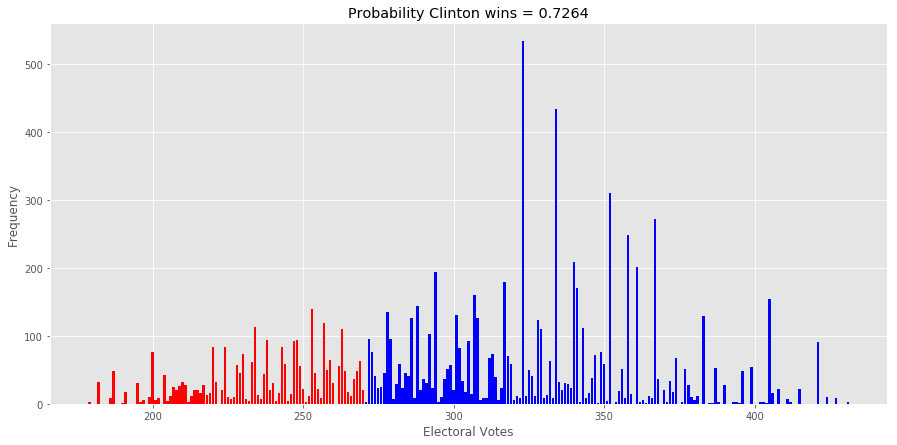

In [96]:
clean_scores = predicted_scores[:, BURN_IN:, :]
e_day_results = clean_scores[-1, :, :]
outcomes = []
clinton_wins = 0
clinton_loses_ec_but_wins = 0
for i in range(10000):
    draw = np.random.randint(0, e_day_results.shape[0])
    outcome = e_day_results[draw]
    outcome = np.dot(outcome >= 0.5, ev_states)
    if outcome > 270:
        clinton_wins += 1
    else:
        if general_score[-1, BURN_IN:][draw] > 0.5:
            clinton_loses_ec_but_wins += 1
            
    outcomes.append(outcome)

print(clinton_loses_ec_but_wins / 10000.0)
generate_simulation_hist(outcomes, clinton_wins)

### Brier Score

In [97]:
brier_score = get_brier_score(e_day_results, state_polls)
print(brier_score)

0.0855810023529


In [98]:
results_2016 = pd.read_csv('../data/2016_results.csv', index_col=0, header=None)
results_2016 = results_2016.loc[state_polls.state.unique()].as_matrix().flatten()
for i in range(len(probabilities)):
    print(probabilities[i], state_polls.state.unique()[i], results_2016[i])

1.0 district of columbia 1
0.0 wyoming 0
0.0 west virginia 0
0.0 nebraska 0
0.0 montana 0
1.0 washington 1
0.0012 mississippi 0
1.0 vermont 1
1.0 massachusetts 1
0.0 tennessee 0
0.0 louisiana 0
0.0 south dakota 0
1.0 rhode island 1
0.0 kentucky 0
1.0 oregon 0
0.0 oklahoma 0
0.0 north dakota 0
0.981 new mexico 1
1.0 illinois 1
0.0 idaho 0
1.0 hawaii 1
1.0 delaware 1
1.0 connecticut 1
0.0 arkansas 0
0.005 alaska 0
0.0 alabama 0
0.055 texas 0
0.1356 south carolina 0
0.9086 maine 1
0.0 indiana 0
0.587 nevada 1
0.0 kansas 0
0.82 colorado 1
1.0 new jersey 1
0.0 utah 0
0.0478 georgia 0
0.001 missouri 0
1.0 maryland 1
0.6386 michigan 0
0.3568 arizona 0
0.871 minnesota 1
0.9716 virginia 1
0.1772 iowa 0
0.6724 north carolina 0
0.8746 wisconsin 0
0.2394 ohio 0
0.9516 pennsylvania 0
1.0 new york 1
0.9008 new hampshire 1
1.0 california 1
0.6086 florida 0
